In [50]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import signal
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from os import path
from sklearn import metrics, svm, preprocessing
from sklearn.model_selection import ShuffleSplit

In [10]:
# generamos un electrodo promedio por cada persona 
# (promediando los 5 electrodos del enunciado que se encuentran juntos)
# y los guardamos en disco. De esta manera a partir de ahora vamos a trabajar solo con esos archivos que son 
# mucho más livianos y tiene toda la información que necesitamos, 894 epochs por cada paciente.

electrodos_a_promediar = [7, 43, 79, 130, 184]

for t in ['P', 'S']:
    for i in range(1,11): 
        try:
            data_file = path.join('../../../../../media/libre/CienciaDatos/',t) + "%02d" % (i) + '.mat'
            elec_prom_file = '../../../../../media/libre/CienciaDatos/dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            data = io.loadmat(data_file)['data']
            electrodo_promedio = data[:,electrodos_a_promediar,:].mean(axis=1)
            electrodo_promedio.dump(elec_prom_file)
        except Exception as exception:
            print(str(exception))
            pass

In [11]:
def calculate_welchs(data):
    welchs_by_epoch = np.empty((len(data),2,101))

    for i, epoch in enumerate(data):
        f,p = signal.welch(x=epoch, fs=250)
        welchs_by_epoch[i] = np.array([f,p])
    
    return welchs_by_epoch

In [12]:

welchs = []

for i_type, t in enumerate(['P', 'S']):
    for i in range(1,11):
        try:
            file = '../../../../../media/libre/CienciaDatos/dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            print(file)
            data = np.load(file)
            welchs.append(calculate_welchs(data)) 
            #print(data.shape)
            #print(repr(calculate_welchs(data)))
        except Exception as exception:
            print(str(exception))
            pass

../../../../../media/libre/CienciaDatos/dumps/elec_prom_P01.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P02.dmp


/usr/lib/python3/dist-packages/scipy/signal/spectral.py:278: UserWarning: nperseg = 256, is greater than x.shape[-1] = 201, using nperseg = x.shape[-1]
  % (nperseg, axis, x.shape[axis], axis))


../../../../../media/libre/CienciaDatos/dumps/elec_prom_P03.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P04.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P05.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P06.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P07.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P08.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P09.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_P10.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_S01.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_S02.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_S03.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_S04.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_S05.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_S06.dmp
../../../../../media/libre/CienciaDatos/dumps/elec_prom_S07.dmp
../../../../../media/libre/CienciaDatos/

In [13]:
def calculate_epochs_power_mean(welchs_by_epoch, frequency_range):
    freqs = welchs_by_epoch[0,0,:]
    freqs_idxs = np.where((freqs>=frequency_range[0]) * (freqs<frequency_range[1]))
    return welchs_by_epoch[:,1,freqs_idxs].mean(axis=2)



frequencies_ranges = {"delta": (0,4), "theta": (4,8), "alpha": (8,13), "beta": (13,30), "gamma": (30,125)}
# matriz [paciente,banda_freq,epochs,potencia]

potencias_mean_std = np.zeros((20,5,2))
for i in range(20):
    for freq_idx,frequency_range in enumerate(frequencies_ranges.values()):
        frequency_epochs_power_means = calculate_epochs_power_mean(welchs[i],frequency_range)
        potencias_mean_std[i,freq_idx,0] = frequency_epochs_power_means.mean()
        potencias_mean_std[i,freq_idx,1] = frequency_epochs_power_means.std()

        #frequency_power_means.dump(name + 'power_means.dmp')

In [45]:
column_names_mean = list(map(lambda x: x+"_mean",frequencies_ranges.keys()))
df_mean = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,0]),columns=column_names_mean)
column_names_std = list(map(lambda x: x+"_std",frequencies_ranges.keys()))
df_std = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,1]),columns=column_names_std)

labels = list("P"*10 + "S"*10)
df_labels = pd.DataFrame({"labels":labels})
tabla = pd.concat([df_mean,df_std,df_labels],axis=1)

tabla

,alpha_mean,beta_mean,theta_mean,delta_mean,gamma_mean,alpha_std,beta_std,theta_std,delta_std,gamma_std,labels
0,-0.615562,-0.379001,-0.218471,0.396663,-0.302755,-0.521831,0.339973,0.261873,1.347819,-0.011083,P
1,-0.697214,-0.789972,0.607091,0.744182,-0.251833,-0.662774,-0.849945,0.579520,0.558313,-0.255524,P
2,-0.529110,-0.719364,1.217691,2.341693,-0.537710,-0.551462,-1.009780,1.360804,2.076197,-0.790234,P
3,-0.416142,-0.691706,1.278998,0.554433,-0.595068,-0.376407,-0.650897,1.056425,0.680916,-0.630404,P
4,-0.514352,-0.201509,0.773535,1.675636,0.101856,-0.563331,-0.611527,0.364621,1.224140,-0.098266,P
5,-0.236459,-0.437419,0.077479,0.901231,-0.640304,-0.239606,-0.079983,0.154533,1.017012,-0.801067,P
6,-0.687465,-0.414219,0.216901,0.970526,0.020202,-0.673554,-0.187679,0.053882,0.836438,1.146518,P
7,-0.798531,-1.223064,-0.922865,-0.635332,-0.597714,-0.743112,-1.216148,-0.922583,-0.328200,-0.549706,P
8,-0.621882,-0.520118,1.018432,0.098566,-0.449400,-0.585025,-0.419609,1.046483,-0.031759,-0.663145,P
9,-0.656084,-0.589630,-0.005324,0.986505,-0.408477,-0.638562,-0.354721,0.260192,1.038056,0.221849,P


In [46]:
def graficar_roc(table, values_column_name, labels_column_name,positivo):

    fpr, tpr, thresholds = metrics.roc_curve( \
        table[labels_column_name].values, \
        table[values_column_name].values, \
        pos_label=positivo, drop_intermediate=False)
   
    roc_auc = metrics.auc(fpr, tpr)
   
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {0}'.format(values_column_name))
    plt.legend(loc="lower right")
    plt.show()


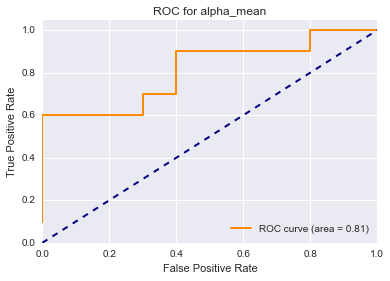

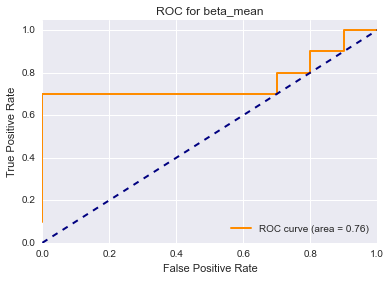

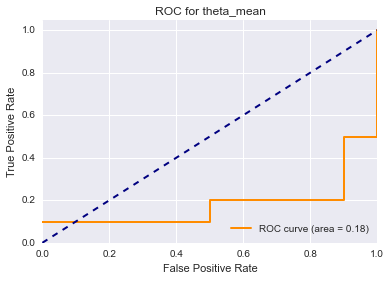

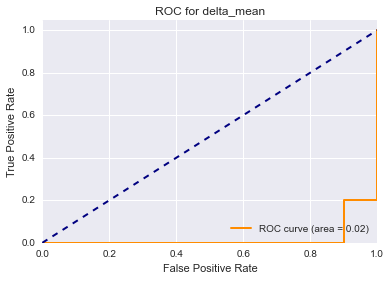

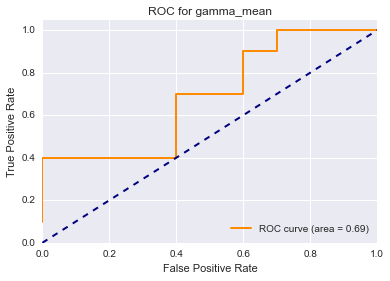

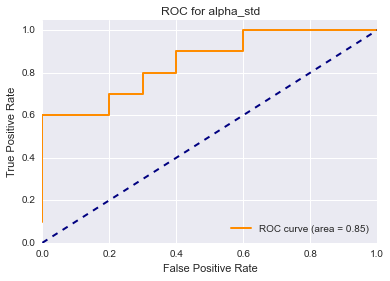

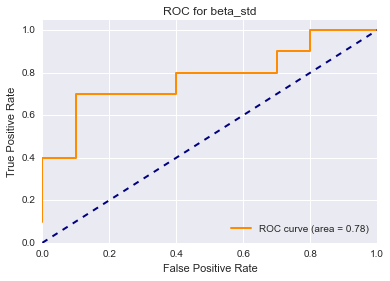

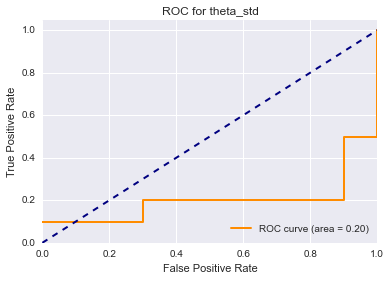

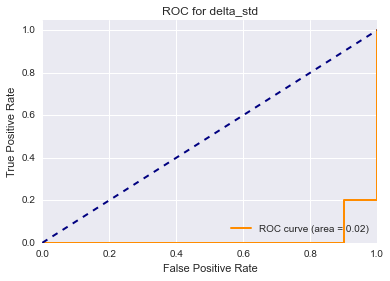

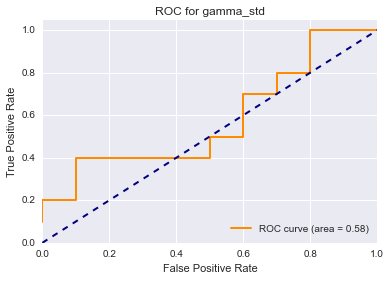

In [47]:
for label in (column_names_mean + column_names_std):
    graficar_roc(tabla,label, 'labels', 'S')


In [68]:


X = np.array([x for x in range(10)])
rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=0)
X_Split = rs.split(X)

Y = np.array([x for x in range(10)])
rs = ShuffleSplit(n_splits=5, test_size=.1, random_state=0)
Y_Split = rs.split(Y)

y_train_index = [x+10 for x in Y_Split[0]]
print(y_train_index)


for train_index, test_index in rs.split(X):
    X_train = tabla.iloc[train_index, :-1]
    y = tabla.iloc[train_index, -1]
    clf = svm.SVC()
    clf.fit(X_train, y)
    print("TRA:", train_index, "TEST:", test_index)
    print(clf.predict(tabla.iloc[test_index, :-1]))

TypeError: 'generator' object is not subscriptable